# Viajes en taxi



In [58]:
import pandas as pd
import duckdb
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np

# Preparación de datos

In [6]:
# importo los datos
company = pd.read_csv('moved_project_sql_result_01.csv')
dropoff = pd.read_csv('moved_project_sql_result_04.csv')

In [11]:
# muestro informacion sobre el dataframe
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [93]:
# muestro el head del dataframe
company.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [8]:
# muestro informacion sobre el dataframe
dropoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [13]:
# muestro el head del dataframe
dropoff.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [21]:
# filtro lis datos para tene solo las 10 comañias con mayor promedio
query = """
SELECT *
FROM dropoff
ORDER BY average_trips DESC
LIMIT 10
"""
top_10 = duckdb.query(query).to_df()
top_10

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


Los dataframes no tenias datos faltantes ni tenían tipos equivocados lo que ahorra mucho tiempo el análisis, ordene el dataframe dropoff sobre los viajes promedio y use la función LIMIT para tener solo los 10 filas que me interesan para hacer la gráfica más adelante.

# Compañías y numero de viajes. 

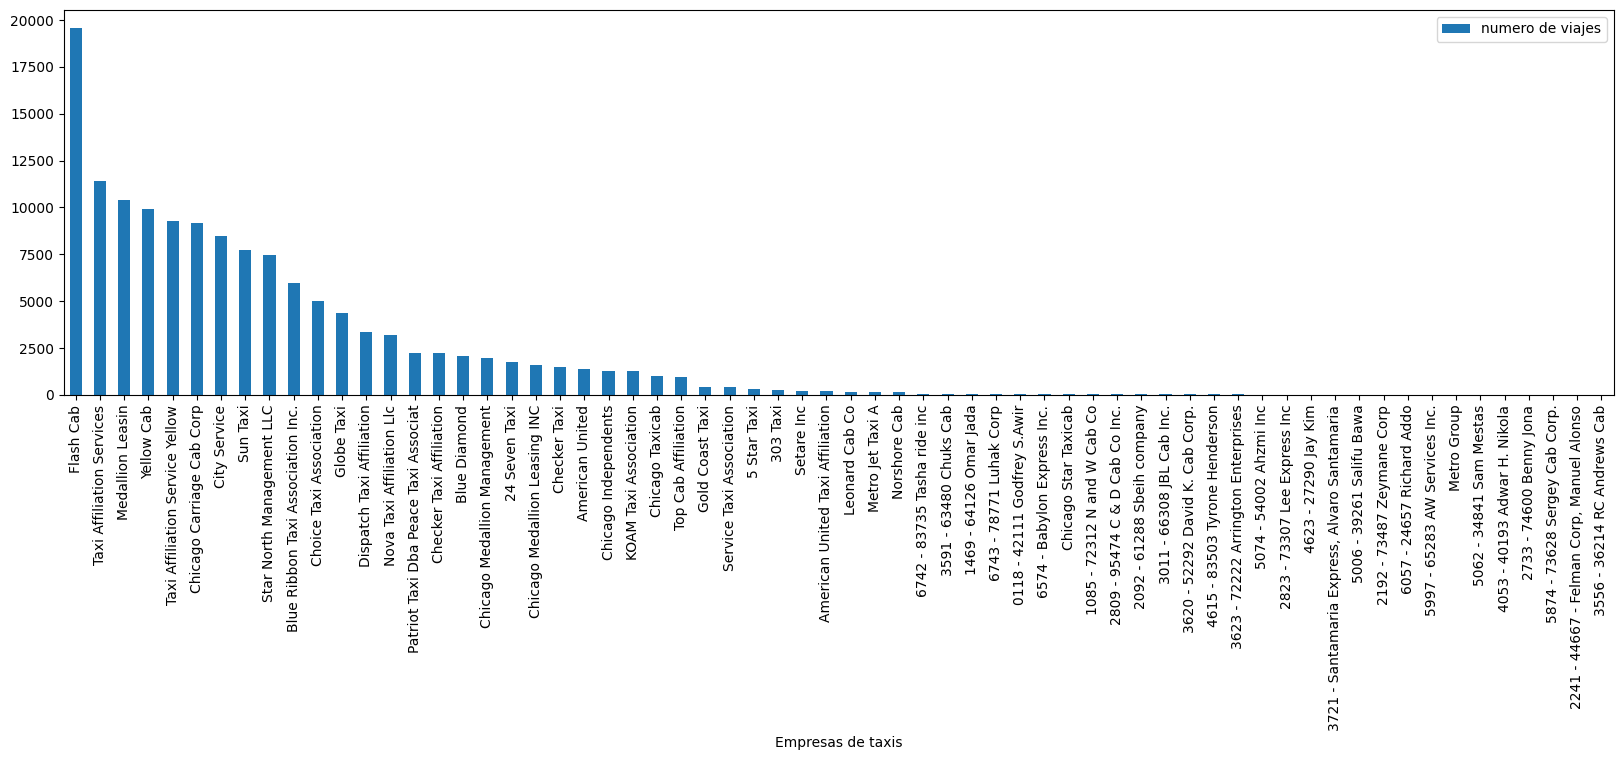

In [46]:
# hago una grafica de barras con los datos de las compañias de taxis y cuantos viajes realisa cada una
company.plot(kind='bar',
            x='company_name',
            y='trips_amount', 
            xlabel='Empresas de taxis',
            figsize=[20, 5])
plt.legend(['numero de viajes'])

Esta grafica muestra el numero de viajes que ha realizado cada compañía, podemos observar que la empresa con mas viajes es Flash Cab con un amplio margen respecto del segundo puesto Taxi Affiliation Services. Además, aunque en el dataframe hay 65 negocios de taxis son solo 25 las que llevan la mayoría de los viajes.

# Top 10 lugares de finalización

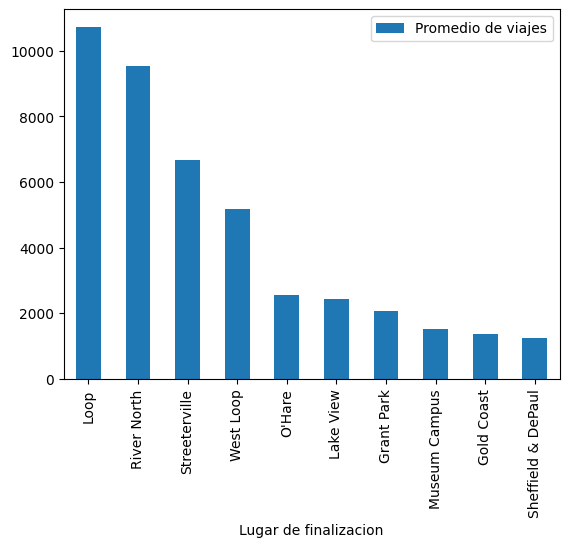

In [48]:
# grafica sobre las 10 compañias con major promedio de viajes
top_10.plot(kind='bar', 
            x='dropoff_location_name',
            xlabel = 'Lugar de finalizacion',
            )
plt.legend(['Promedio de viajes'])

Aquí se presentan los 10 lugares que em promedio mas personas eligen como lijar de destino al usar los servicios de taxis con Loop como el lugar con más finalización de viajes, seguido por River North y en 3 lugar por un margen considerable Streeteville.

# La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos

In [51]:
# importo los los datos de la tabla sobre el clima de los sabados
clima = pd.read_csv('moved_project_sql_result_07.csv')

In [52]:
# muestro informacion sobre el dataframe
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [56]:
# muestro el head de la tabla
clima.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [87]:
# filtro la tabla para que solo muerte los dias conmal clima 
bad = """
SELECT *
FROM clima
WHERE weather_conditions = 'Bad'
"""
# filtro la tabla para que solo muestre los dias con buen clima
good = """
SELECT *
FROM clima
WHERE weather_conditions = 'Good'
"""
bad_day = duckdb.query(bad).to_df()
good_day = duckdb.query(good).to_df()
bad_day.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-04 16:00:00,Bad,2969.0
1,2017-11-18 12:00:00,Bad,1980.0
2,2017-11-04 17:00:00,Bad,2460.0
3,2017-11-04 16:00:00,Bad,2760.0
4,2017-11-18 12:00:00,Bad,2460.0


Después de dividir los datos en días con buen clima y días con mal clima de hace un prueba Levene para para saber si la varianza es la misma.
Hipótesis nula: las varianzas son iguales.
Hipótesis alternativa: las no son iguales
Con un valor Alpha de 5%.

In [89]:
# convierto la columan duration_seconds de ambas tablas en array para las pruebas de hipotesis 
bad_time = np.array(bad_day['duration_seconds'])
good_time = np.array(good_day['duration_seconds'])
#prueba para saber si las varianzas son iguales
alpha = .05
varianzas = st.levene(bad_time, good_time)
print('hipotesis nula: las varianzas son iguales:')
if varianzas.pvalue < alpha:
     print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')

hipotesis nula: las varianzas son iguales:
No podemos rechazar la hipótesis nula


Una ves comprobamos las varianzas pasamos a la prueba T para saber si el promedio de duración de los viajes los sábados lluviosos es diferente de los sábados con buen clima.
Hipótesis nula: los promedios son iguales.
Hipótesis alternativa: los promedios son diferentes.
Con un valor Alpha de 5%.

In [94]:
# prueba para saber si los promedios son iguales
resultado = st.ttest_ind(bad_time, good_time, equal_var=True)
print('el valor de p es:', resultado.pvalue)
if resultado.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')

el valor de p es: 6.517970327099473e-12
Rechazamos la hipótesis nula


# Conclusión general

No se perdió tiempo en la limpieza de los dataframes lo que resalta la importancia de la captura de datos.

Aun que en general no hay una diferencia abrumadora entre las principales compañias de taxis Flas Cab es sin duda la mas dominante.

El destino mas solicitado en promedio es Loop, seguido por River North por relativamente poco las diferencias entre cada puesto y sus puestos adyacentes no es demasiada.

Y por ultimo el promedio de duración de los viajes desde Loop y al aeropuerto se ve alterado dependiendo del clima dependiendo del clima.
